In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
import scipy
import pymc3 as pm
import empiricaldist
from empiricaldist import Pmf

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors



# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-03-01'
end_date ='2021-05-31'

# name of the output folder:
name_of_project = 'femhygiene'

dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfDims = pd.read_csv("resources/corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# map location slug to the proper city name
city_map = dfBeaches['city']

# map locations to feature names
location_wname_key = dfBeaches.water_name_slug

# End period plastics

_End period plastics_ initiated by Ella Daish, is a campaign to eliminate plastics in feminine hygiene products (FHP).  The campaign includes meetings throughout Europe with manufactures, suppliers and vendors of plastic FHP as well as data related to the presece of these items in lakes and rivers in the region. FHP, as well as many other personal hygiene items, are a regular feature of beach litter surveys. Ella was keen to do a litter survey and collect data regarding the abundance of these objects on the shores of Lake Geneva.

Ella did have time and transportation constraints that limited her choice of survey locations:

* access with public transport

* seeking a specific type of object (plastic feminine hygiene products

* preferably a location where this object has been previously identified 

She summarized her preferences and constraints in the following way:

> She only had three hours and would prefer to go to a place where she would likely find one.

Tampon applicators are part of a group of objects that are found on the beach that most likely originate from a toilet or a waste water treatment facility. Depending on the methods used at a water treatment facility the objects pass in between whatever system is in place for collecting inorganic solids in the waste water. This is a common problem and has been linked to older or undersized facilities.


__The Challenge__

Maximze the possibility of finding a specifc object at one beach-litter survey within the defined geographic and temporal bounds given the data from the previous surveys.

> The objects of interest: tampons and tampon applicators.

> Geographic bounds: City of Geneva and accessible by public transport

> Temporal bounds: no more than four hours including transport

The parameter that is being maximized is $\theta$, the probability of finding one FHP object at a beach-litter survey.

## The probability of finding one FHP on the beach in Lac Léman

### Historical data

The first sample was recorded on Lac Léman on November 23, 2015. Between November 2015 and June 2021 there were 247 beach-litter surveys. On a per sample basis, FHP were present in 102 samples (41%). In total there were 78,104 objects removed and identified, of which 358 objects were either tampons or tampon applicators (0.45%). A quick esitmate of the probability of finding one FHP on the beach could be 41%, the ratio of the number of samples where at least one FHP was found (102) to the total number of samples (227). While FHP objects are found on the lake with a probability of 41% they represent a small portion of the total inventory of objects identified.

There are three seperate sampling periods that were identified on Lac Léman. The sampling periods are not of the same length and the sampling frequency is not fixed, except for a few specific locations in period two and three. There were no samples collected in Geneva during sampling period two.

> Period one: 2015-11-15 to 2017-03-01; the first project on Lac Léman (MCBP)

> Period two: 2017-04-01 to 2018-05-01; the Swiss Litter Report (SLR)

> Period three: 2020-03-01 to 2021-11-01; the start of IQAASL up to two weeks before the survey with Ella

Another way to estimate the probability is to assume that it falls between the minimum and maximum observed values for the different survey periods. For example, an estimate of the probability of finding an FHP (y/n)  on the lake could be 34% - 71% and for Geneva 0 - 25%, see tables below. 

In [2]:
# all data since 2015
ldb = pd.read_csv(f"resources/fhg.csv")

# assign loc_date
ldb['loc_date'] = list(zip(ldb.location, ldb['date']))

# date to datetime
ldb['date'] = pd.to_datetime(ldb['date'], format="%Y-%m-%d")

# agg levels
samp_loc = ['loc_date', 'location']
ldate = ['loc_date']
city = ['Genève']

# agg columns
qandp = {'quantity':'sum', 'pcs_m':'sum'}
qandnsamps = {'quantity': 'sum', 'loc_date':'nunique'}

# agg codes and groups
code = ['G144', 'G96']
groupname = ['waste water']

# masks for the data:
# p1 = (ldb['date']<= start_date)
# p2 =(ldb['date'] >= start_date)&(ldb['date'] <= end_date)
sg = ldb.city.isin(city)
fhw = (ldb.groupname.isin(groupname))
fhg = ldb.code.isin(code)
gzero = ldb.quantity > 0

# define the sampling periods

# year one
y_o_s = "2015-11-15"
y_o_e = "2017-03-31"

# year two
y_t_s = "2017-04-01"
y_t_e = "2018-05-01"

# year three
y_th_s = "2021-11-01"

# map the periods to the data
y_one = ldb['date'] <= y_o_e
y_two = (ldb['date'] >= y_t_s) & (ldb['date'] <= y_t_e)
y_thre = (ldb['date'] > start_date) &(ldb['date'] <= y_th_s)

# make a seperate df for each
year_one = ldb[y_one].copy()
year_two = ldb[y_two].copy()
year_three = ldb[y_thre].copy()

# store the dfs in an array
dfs =  [year_one, year_two, year_three]

# # convenience functions to get the number of samples greater than zero
# # for each groupname or list of codes
# def groupname_greater_than_zero(df, groupname, qandp):
#     agg = {'pcs_m':'sum', 'quantity':'sum'}
#     a=df.groupby(['loc_date', 'groupname'], as_index=False).agg(qandp)
    
#     return a[(a.groupname == groupname) & (a.quantity > 0)].loc_date.nunique()

# def code_vals_greater_than_zero(df, codevals, qandp):
#     agg = {'pcs_m':'sum', 'quantity':'sum'}
#     a=df.groupby(['loc_date', 'code'], as_index=False).agg(qandp)
    
#     return a[(a.code.isin(codevals)) & (a.quantity > 0)].loc_date.nunique()

# totals for each survey
ldbdt = ldb.groupby(samp_loc, as_index=False).agg(qandp)

# map location to survey totals
ldbtqmap = ldbdt.set_index(ldate)['quantity']
ldbtpmap = ldbdt.set_index(ldate)['pcs_m']

# summarize all instances at all locations
# the total objects per location, number of samples, number of target objects, number of samples with target objects
adlt = ldb.groupby(['city','location']).agg(qandnsamps)

adlt.rename(columns={'loc_date':'n samples', 'quantity':'qd'}, inplace=True)
foundfhg =ldb[fhg&gzero].groupby(['city','location']).agg(qandnsamps)

fhg_summary = pd.concat([adlt,foundfhg], axis=1)
fhg_summary.fillna(0, inplace=True)
fhg_summary.rename(columns={'quantity':'q_fhg', 'loc_date':'s_pos'}, inplace=True)

# summarize the data

# the number of samples
nsamps = ldb.loc_date.nunique()

# the number of samples with at least one object of interest
nsampsfhg = ldb[fhg&gzero].loc_date.nunique()

# the number of samples with at least one waste water object:
nsampsww = ldb[fhw&gzero].loc_date.nunique()

# the ratio of samples with at least one waste water object with respect to all the samples
# nsampsww/nsamps # 0.91 

# the ratio of all waste water objects found to all objects found
awwt = ldb[ldb.groupname == 'waste water'].quantity.sum()
adq = ldb.quantity.sum()
# awwt/adq 0.07

# the ratio of samples with at least one fhg object with respect to all the samples:
# nsampsfhg/nsamps 0.41

# the ratio of all fhg produ.grocts found to all objects found:
afhg = ldb[(ldb.code.isin(code))].quantity.sum()

# afhg/adq 0.004
          
# summarize the time periods
# the number of samples per period and the number of samples that were positive per period
# waste_water = [groupname_greater_than_zero(x, 'waste water', qandp) for x in dfs]
# fhp = [code_vals_greater_than_zero(x, ["G144", "G96"], qandp) for x in dfs]
# nsamps = [x.loc_date.nunique() for x in dfs]


_table one: total number of locations, samples (n) and positive samples (y) per period on Lake Geneva. The value of y/n in period two is over 50%._

In [3]:
# assign a period to each sample
ldb['period'] = 1
ldb.loc[y_two, 'period'] = 2
ldb.loc[y_thre, 'period'] = 3

# identify the zero values
just_fhg = ldb[fhg].copy()
just_fhg['found'] = False
just_fhg.loc[(just_fhg.quantity > 0), 'found'] = True

# count the positive values y for each period and region
geneva = just_fhg[sg]
summary_geneva = geneva.groupby('period', as_index=False).agg({'location':'nunique', 'loc_date':'nunique', 'found':'sum'})
summary_geneva.rename(columns={'loc_date':'n','found':'y', 'location':'locations'}, inplace=True)

#there were  no samples in Geneva durring the second sampling period
summary_geneva.loc[2] = 2,0, 0, 0
summary_geneva.sort_values(by='period', inplace=True)
summary_geneva.reset_index(drop=True, inplace=True)
geneva_yn = [(summary_geneva.loc[x].y, summary_geneva.loc[x].n) for x in  summary_geneva.index]

summary_just_fhg = just_fhg.groupby('period', as_index=False).agg({'location':'nunique', 'loc_date':'nunique', 'found':'sum'})
summary_just_fhg.rename(columns={'loc_date':'n','found':'y', 'location':'locations'}, inplace=True)
summary_just_fhg

/home/mwshovel/anaconda3/envs/ppenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


,period,locations,n,y
0,1,25,102,35
1,2,11,46,33
2,3,24,99,39


_table two: total number of locations, samples (n) and positive samples (y) per period on in Geneva. There are no samples in period two._

In [4]:
summary_geneva

,period,locations,n,y
0,1,2,12,2
1,2,0,0,0
2,3,4,16,4


In Geneva there were 16 samples in period three and 12 samples in the first period. Using the same method as above the range of probable values in Geneva ranges from 0 to 66%. A probability of 0 is not realistic and 12/28 samples are almost four years old. The range of possible values reflects how uncertain any prediction may be using these methods.

_table three: locations, samples (n) and positive samples (y) per location in Geneva._

In [5]:
glocs_summary = geneva.groupby(['location', 'period'], as_index=False).agg({'loc_date':'nunique', 'fail':'sum'})
glocs_summary.rename(columns={'loc_date':'n','fail':'y', 'location':'locations'}, inplace=True)
glocs_summary

,locations,period,n,y
0,baby-plage-geneva,3,11,3
1,baby-plage-ii-geneve,3,2,0
2,jardin-botanique,1,3,2
3,rocky-plage,3,1,0
4,villa-barton,1,9,0
5,villa-barton,3,2,1


Villa-barton had 0/9 samples in the first period and 1/2 in the third period. Jardin-botanique had 2/3 in period one but has not been sampled since. To account for the results from prior  sampling periods bayesian inference will be used to estmate the location in Geneva that may have the highest value of $\theta$ with respect to the other locations given the previous survey results.

### Method

For each sampling period the proportion of samples that have at least one recorded instance of an FHP (y) with respect to the total number of samples (y/n), is the parameter of interest: $\theta$. Sequential Bayesian analysis is used to determine the probable values of $\theta$ given the sample results and the different sampling periods.

$$p({\theta} | y) = \frac{p(\theta)p(y | \theta)}{p(y)}$$

The distribution of y is a binomial random variable that can be summarized according to a binomial distribution.

$$p(y|\theta) =  Bin(y|n,\theta)$$

&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;$$ = {n \choose y} \theta^y (1-\theta)^{ n-y }$$

This sampling model was chosen because it is assumed that the the probability of finding an FHP object is the same for all locations in the region of interest, Lake Geneva. To start the temporal analysis an initial estimate of $\theta$ prior to the start of sampling must be made. {cite}`bayesianDataAnalysisThird`

__initial estimates__

When sampling started in 2015 there were no reference values for the region. Count surveys of litter data in the maritime environment had produced volumes of data but under significantly different conditions. Without reference values we had no prior assumptions on the probability of finding an FHP product and assumed the probability was $\approx$ for all locations on the lake. The parameter that is being evaluated, $\theta$, is bounded by zero and one making the Beta binomial distribution with $\alpha$=1 and $\beta$=1 a fair evaluation of expectations based on the knowledge at the time.

The assumed distribution of $\theta$ **prior** to November 2015 is therefore $\theta \sim Beta(1,1)$. Which is a conjugate prior of the binomial distribution. This results in a closed form posterior density and predictable methods for updating the p($\theta$ | data) from one sampling period to the next.

__likelihood function__

The likelihood function $pr(y|n,\theta) = \theta^y (1-\theta)^{ n-y }$ is the PMF of the sampling model $Bin(y|n,\theta)$ without the factor ${n \choose y}$ because those fixed values are not dependent on the value of $\theta$. {cite}`bayesianDataAnalysisThird`

__updating the probability__

The posterior density for $\theta$ is the product of the prior distribution and the likelihood:

prior = $\theta^{\alpha - 1}(1−\theta)^{\beta - 1}$

likelihood =  $\theta^y (1-\theta)^{ n-y }$

prior * likelihood = $\theta^{\alpha - 1 + y} (1 - \theta)^{\beta - 1 + n - y}$

The posterior distribution is an unormalized beta distribution with parameters $\alpha + y$ and $\beta + n - y$. This means that the **prior** uninformed estimate in November 2015 can be updated with the data from each sampling period in sequence. Using this method the results from sampling period one (which incorporate the initial estimate) become the **prior** distribution for the results of sampling period two and this process is repeated until the last sampling period. For example:

_Sampling period one example_

$\theta \sim Beta(1,1)$ = estimate $\theta$ prior to sampling

n - y = number of samples in period one WITHOUT an FHP

y = number of samples in period one WITH at leat one FHP

_apply n and y from the observed results to the initial estimate:_

$\theta \sim Beta( \beta = 1 + y, \alpha = 1 + n - y)$ = the estimated probability after period one **and** the prior distribution (initial estimate) for period two.


__Assumptions__

* The samples are independent and identically distributed
* $\theta$ is equal for all locations which is the expected value for the lake
* The expected result for the lake or the region is the best estimate for locations without samples

For locations that do not have samples durring a sampling period the assumed result is $\approx$ to the y, n for the lake. The results for the lake are reduced to approximate the ratio y/n without overpowering the results from individual locations:

1. period one: y=31, n=94 $\approx$ y=1, n=3
2. period two: y=29, n=46 $\approx$ y=3, n=5
3. period three: y=38, n=99 $\approx$ y=2, n=5

This type of **prior** is intended to be informative and will have an impact on the final results. The model is repeated using using both values from the lake.

## The probability of finding one FHP

The expected probability of finding one FHP on a beach on Lake Geneva is between 35% and 47% (95%ETI) with an expected mean of 41%. If the survey results are restricted to the City of Geneva the expected probabaiity is between 10% and 40% (95%ETI) and an expected mean of 23%.

**_Figure one:_** _Probability of $\theta$ over time: The posterior distributions of the three sampling periods. **Left**: Lake Geneva, the expected probability of $\theta$ was 41%, at the end of sampling period 3 the observed value of $\theta$ was 38%. **Right:** City of Geneva. The observed value of $\theta$ in the third period was 25% versus the expected value of 21%._

In [6]:


def make_beta(alpha, beta):
    """Makes a beta object. Taken from Alen Downey ThinkBayes2.
    
    Returns a beta distribution with values assigned to Alpha, Beta    
    """
    dist = scipy.stats.beta(alpha, beta)
    dist.alpha = alpha
    dist.beta = beta
    
    return dist

def update_beta(prior, data):
    """Update a beta distribution. 
    Taken from Alen Downey ThinkBayes2. Updates a prior beta
    distribution.
    
    Args:
        y (int): number of samples where one was found
        n (int): number of samples
    
    Returns:
        An updated beta distribution
    
    """
    k, n = data
    alpha = prior.alpha + k
    beta = prior.beta + n - k
    
    return make_beta(alpha, beta)

def get_n_y_codes(df, args, groups, quantity):
    
    data = df.loc[df.code.isin(args)].groupby(['location','loc_date'], as_index=False).quantity.sum()
    val = data[data.quantity > 0].loc_date.nunique()
    days = data.loc_date.nunique()
    
    return (val, days)

def update_sampling_periods(prior, vals):
    """Updates the prior with the y/n values from the current period.
    """
    
    yone = update_beta(prior, vals[0])
    ytwo = update_beta(yone, vals[1])
    ythr = update_beta(ytwo, vals[2])
    
    return [yone, ytwo, ythr]

# initial assumptions
# a uniform distribution 

alpha = 1
beta = 1
prior = make_beta(alpha,beta)

# objects of interest
args=["G144", "G96"]

# data by sampling period
years = [year_one, year_two, year_three]

# values of y and n for each sampling period
valls = [get_n_y_codes(x, args, ['location','loc_date'], 'quantity') for x in years]

# the posterior distributions for each sampling period
lake_posteriors = update_sampling_periods(prior, valls)

# draw some posterior samples
r = lake_posteriors[0].rvs(size=1000)
q = lake_posteriors[1].rvs(size=1000)
t = lake_posteriors[2].rvs(size=1000)

# limit data to geneva
yearsg = [ldb[(y_one)&(sg)].copy(), ldb[y_two&sg].copy(),ldb[y_thre&sg].copy()]

glocs = ldb[sg].location.unique()

valsg = [get_n_y_codes(x, args, ['location','loc_date'], 'quantity') for x in yearsg]

# posterior samples from geneva
geneva_posteriors = update_sampling_periods(prior, valsg)

# draw some posterior samples
rg = geneva_posteriors[0].rvs(size=1000)
qg = geneva_posteriors[1].rvs(size=1000)
tg = geneva_posteriors[2].rvs(size=1000)

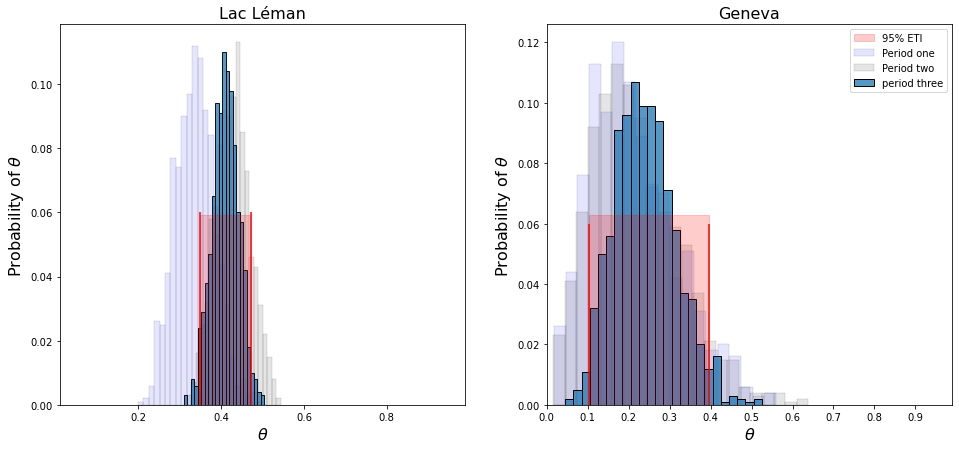

In [7]:
fig, axs = plt.subplots(1,2, figsize=(16,7))

ythr_pos = lake_posteriors[2]
ythr_posg = geneva_posteriors[2]

ax=axs[0]
ax2=axs[1]
sns.histplot(np.sort(r), stat='probability', color= 'blue', alpha=0.1, linewidth=.1, ax=ax, label='Period one')
sns.histplot(np.sort(q), stat='probability', color='black', alpha=0.1, linewidth=.1, ax=ax, label='Period two')
sns.histplot(np.sort(t), stat='probability', ax=ax, label="period three")
ax.vlines(x=ythr_pos.interval(.95)[0], ymin=0, ymax=0.06, color='red')
ax.vlines(x=ythr_pos.interval(.95)[1], ymin=0, ymax=0.06, color='red')
# ax.hlines(y=.03, xmin=ythr_pos.interval(.95)[0], xmax=ythr_pos.interval(.95)[1])
ax.axvspan(xmin=ythr_pos.interval(.95)[0], xmax=ythr_pos.interval(.95)[1], ymin=0, ymax=.5, fill='x', zorder=100, alpha=0.2, color='red', label="95% ETI")
ax.set_xlim(.01,.99)
ax.set_xlabel(r"$\theta$", fontsize=16)
ax.set_ylabel(r"Probability of $\theta$", fontsize=16)
ax.set_title("Lac Léman", fontsize=16)


sns.histplot(np.sort(rg), stat='probability', color= 'blue', alpha=0.1, linewidth=.1, ax=ax2, label='Period one')
sns.histplot(np.sort(qg), stat='probability', color='black', alpha=0.1, linewidth=.1, ax=ax2, label='Period two')
sns.histplot(np.sort(tg), stat='probability', ax=ax2, label="period three")
ax2.vlines(x=ythr_posg.interval(.95)[0], ymin=0, ymax=0.06, color='red')
ax2.vlines(x=ythr_posg.interval(.95)[1], ymin=0, ymax=0.06, color='red')
# ax.hlines(y=.03, xmin=ythr_pos.interval(.95)[0], xmax=ythr_pos.interval(.95)[1])
ax2.axvspan(xmin=ythr_posg.interval(.95)[0], xmax=ythr_posg.interval(.95)[1], ymin=0, ymax=.5, fill='x', zorder=100, alpha=0.2, color='red', label="95% ETI")
ax2.set_xlim(.01,.99)
ax2.set_xlabel(r"$\theta$", fontsize=16)
ax2.set_ylabel(r"Probability of $\theta$", fontsize=16)
ax2.set_title("Geneva", fontsize=16)
plt.xticks(np.arange(0, 1, .1))

plt.legend()
plt.show()

### The probability of finding an FHP at a particular beach

The probability of finding one FHP at a specific beach depends on the beach that is visited. Geneva is at the end of a lake and has expanded over the years to include both the left and right bank of Lac Léman. There are no survey locations at the Rhône out fall, the shoreline in this area is well developed to support structures like the Sujets Dam and Mont Blanc Bridge. As a result, the survey locations in Geneva are either on the right or left bank of the lake.

Getting from one side of the lake to the other on public transport can take up to an hour, which is 1/3 of the time allotted for the whole experiment. Therfore, a choice needs to be made as to which side of the lake to search.

An initial assessment was made for each location by dividing the number of samples with FHP by the total number of samples for each location ($\frac{y_{tot}}{n_{tot}}$). Using this method we are ignoring the values from the other samples that were collected on the same lake within the same time frame.

*__Figure two:__ map of survey results* *The locations in Geneva are separated by the lake and the downtown area. The value of $\frac{y_{tot}}{n_{tot}}$ for all surveys at each of the locations is given as the diameter of the marker for the locations of interest. Using this method it appears that jardin-botanique  or baby-plage-geneva are the front runners.*


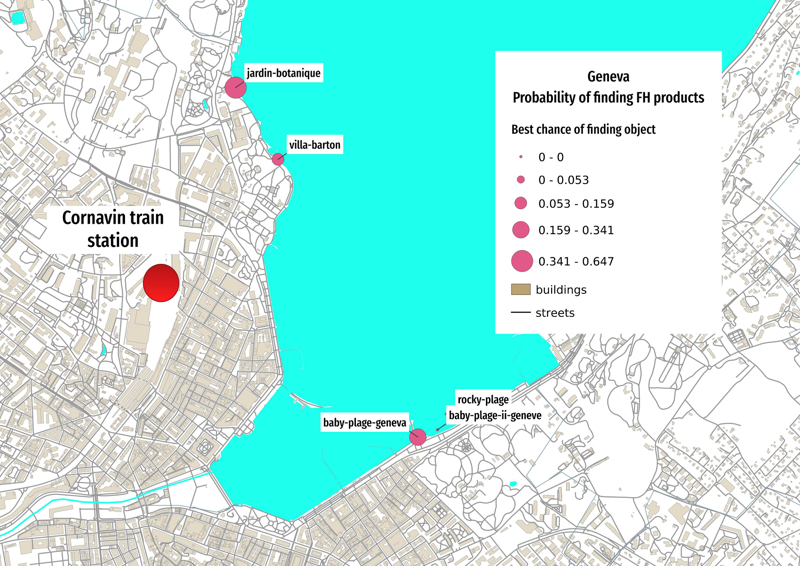

In [8]:
output = io.BytesIO()
bassin_map = PILImage.open("resources/images/locgeneve.jpeg")
bassin_map.thumbnail((800, 1200))
bassin_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

In [9]:
# if no samples were taken for a location durring a sampling period 
# the assumed parameters are the y and n for the region under consideration
# this means we assume that the probability of finding an object at a particular 
# location is closely related to the probability of finding an object in the region
# which is the same as our initial assumption that the probability was  essentially the 
# same everywhere

def insert_prior_vals(l, obs, priors_region, num_periods=3, one_minus=False):
    
    """Inserts the y and n values from the region as updates for locations that have no
    samples during the current sampling period.
    """
    
    data = obs.loc[obs.locations == l]
    wiw = {l:[]}
    
    for a_p in np.arange(num_periods):
        p=a_p + 1
        # get the observed y and n values for the period
        n = data.loc[data.period==p, 'n'].sum()
        y = data.loc[data.period==p, 'y'].sum()
        
        if n == 0:
            # use the y and n values for the region to update the prior
            y_n = priors_region[a_p]
        else:
            y_n = (y,n)
        if one_minus:
            y_n = (n-y, n)
        else:
            pass
        
        wiw[l].append(y_n)
    
    return wiw

def replace_with_next_level(regional, lake, glocs):
    """Replaces any y=0, n=0 with the lake values for any period
    """
    wiw = {}
    for adict in regional:
        l = list(adict.keys())[0]
        data = adict[l]        
        new_data = {l:[]}
        
        for i,a_tup in enumerate(data):
            if sum(a_tup) == 0:
                new_tup = lake[i]
            else:
                new_tup = a_tup
            new_data[l].append(new_tup)
        
        wiw.update(new_data)
    
    return wiw
            
                
        
# this sets the results for each sampling period based on the results from the previous for that location or the reduced values for the lake
updates_g = [insert_prior_vals(l, glocs_summary, [(1,3), (3,5),(2,5)], num_periods=3) for l in glocs]

# get the number of times that one was not found.
updates_g_neg = [insert_prior_vals(l, glocs_summary, [(1,3), (3,5),(2,5)], num_periods=3, one_minus=True) for l in glocs]

# this sets the results for each sampling period based on the results from the previous for that location or the lake
update_vals_l = [insert_prior_vals(l, glocs_summary, valls, num_periods=3) for l in glocs]

# get the number of times that one was not found.
update_vals_lneg = [insert_prior_vals(l, glocs_summary, valls, num_periods=3, one_minus=True) for l in glocs]

updates_gk = {}
for i,l in enumerate(glocs):
    c=update_sampling_periods(prior, updates_g[i][l])
    updates_gk.update({l:c})

updates_gkneg = {}
for i,l in enumerate(glocs):
    c=update_sampling_periods(prior, updates_g_neg[i][l])
    updates_gkneg.update({l:c})
    
updates_l = {}
for i,l in enumerate(glocs):
    c=update_sampling_periods(prior, update_vals_l[i][l])
    updates_l.update({l:c})
    
updates_lneg = {}
for i,l in enumerate(glocs):
    c=update_sampling_periods(prior, update_vals_lneg[i][l])
    updates_lneg.update({l:c})

__Weak prior:__ $p(\theta_{geneva})$ is similar but different to $p(\theta_{lake})$

Under this Hypothesis the variance remains high for all the locations, making it difficult to choose a clear winner. However, jardin-botanique remains the front runner even though the p($\theta$) has declined from the initial estimate. The probability of not finding an FHP is greatest at villa-barton. 

**_Figure three:_** *Distribution of $p(\theta)$ and the probability of not finding an FHP for each location in Geneva. Under this assumption the variance is relatively high and the results from local samples carry equal weight with respect to lake samples.* 

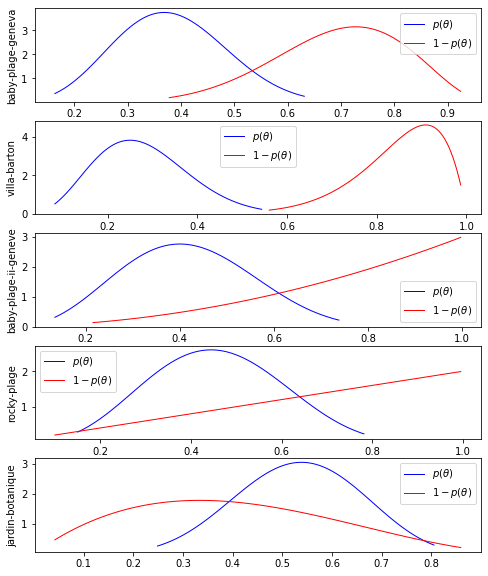

In [10]:
fig, axs = plt.subplots(5,1, figsize=(8,10))

beach_colors = ["indianred", "sienna", "olivedrab", "violet", "dodgerblue"]

for i, l in enumerate(glocs):
    x = np.linspace(updates_gk[l][-1].ppf(0.01), updates_gk[l][-1].ppf(0.99), 100)
    xneg = np.linspace(updates_gkneg[l][-1].ppf(0.01), updates_gkneg[l][-1].ppf(0.99), 100)
    sns.lineplot(x=x, y=updates_gk[l][-1].pdf(x), color="blue", alpha=1, linewidth=1,  ax=axs[i], zorder=1, label=r"$p(\theta)$")
    sns.lineplot(x=xneg, y=updates_gkneg[l][-1].pdf(xneg), color="red", alpha=1, linewidth=1,  ax=axs[i], zorder=1, label=r"$1-p(\theta)$")
    axs[i].set_ylabel(l)

plt.show()

The mean, mode, 50% ETI and variance of the posterior distribution under the assumption that $p(\theta_{geneva})$ is fairly close to  $p(\theta_{lake})$ but different

In [11]:
for i, l in enumerate(glocs):
    interval = updates_gk[l][-1].interval(.5)
    mean = updates_gk[l][-1].mean()
    mode = (updates_gk[l][-1].alpha-1)/(updates_gk[l][-1].alpha+updates_gk[l][-1].beta-2)
    var = updates_gk[l][-1].var()
    print(f"{l}: mean={ np.round(mean,2) }, mode={np.round(mode,2)}, [25% - 75%]=({np.round(interval[0],2), np.round(interval[1],2)}), variance={np.round(var, 2)}")

baby-plage-geneva: mean=0.38, mode=0.37, [25% - 75%]=((0.31, 0.45)), variance=0.01
villa-barton: mean=0.28, mode=0.25, [25% - 75%]=((0.2, 0.34)), variance=0.01
baby-plage-ii-geneve: mean=0.42, mode=0.4, [25% - 75%]=((0.32, 0.51)), variance=0.02
rocky-plage: mean=0.45, mode=0.44, [25% - 75%]=((0.35, 0.56)), variance=0.02
jardin-botanique: mean=0.53, mode=0.54, [25% - 75%]=((0.45, 0.62)), variance=0.02


Predicted sample results:

In [12]:
def simulate_one_draw(updates, sampledist, labels, size=10):
    wiw={}
    ptotals = {}
    for i, l in enumerate(labels):

        ptheta = updates[i]
        p = ptheta.rvs(size=size)
        succes=0
        for ap in p:
            res = sampledist(1,ap).rvs(1)
            succes += res[0]
            

        wiw.update({l:succes})
        
    return wiw

updates = [updates_gk[l][-1] for l in glocs]

posterior_samples= simulate_one_draw(updates, scipy.stats.binom, glocs, size=1)
posterior_samples

{'baby-plage-geneva': 1,
 'villa-barton': 0,
 'baby-plage-ii-geneve': 1,
 'rocky-plage': 1,
 'jardin-botanique': 1}

__Strong prior__ $p(\theta_{geneva})$ is $\approx$ to $p(\theta_{lake})$

Under the assumption that p($\theta$) in Geneva is $\approx$ to the rest of the lake, the variance of p($\theta$) is reduced at all locations. Because of the overwhelming number of samples on the lake, the past local results have little effect on p($\theta$) as more sampling periods are considered. As a result the latest sample data for villa-barton (1/2 in period three) has more of an influence under this assumption than the results from the first year (0/9).

**_Figure four:_** *Distribution of $p(\theta)$ and the probability of not finding an FHP for each location in Geneva. Under this assumption the variance is relatively low when compared to the previous model. When the lake results are used the influence of the first sampling period is reduced, thus increasing $p(\theta)$ at villa barton and reducing the early advantage of jardin-botanique.* 

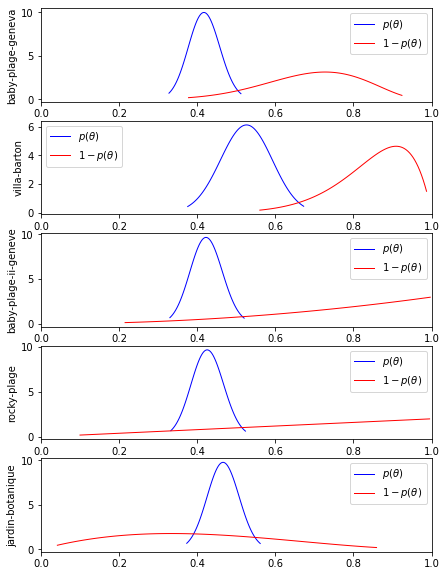

In [13]:
fig, axs = plt.subplots(5,1, figsize=(7,10))

beach_colors = ["indianred", "sienna", "olivedrab", "violet", "dodgerblue"]

for i, l in enumerate(glocs):
    
    xi = np.linspace(updates_l[l][-1].ppf(0.01), updates_l[l][-1].ppf(0.99), 100)
    xneg = np.linspace(updates_lneg[l][-1].ppf(0.01), updates_lneg[l][-1].ppf(0.99), 100)
    sns.lineplot(x=xi, y=updates_l[l][-1].pdf(xi), color="blue", alpha=1, linewidth=1,  ax=axs[i], zorder=1,  label=r"$p(\theta)$")
    sns.lineplot(x=xneg, y=updates_lneg[l][-1].pdf(xneg), color="red", alpha=1, linewidth=1,  ax=axs[i], zorder=1, label=r"$1-p(\theta)$")
    axs[i].set_ylabel(l)
    axs[i].set_xlim(0,1)

plt.show()

The mean, mode, 50% ETI and variance of the posterior distribution under the assumption that $p(\theta_{geneva})$ $\approx$ $p(\theta_{lake})$

In [14]:
for i, l in enumerate(glocs):
    interval = updates_l[l][-1].interval(.95)
    mean = updates_l[l][-1].mean()
    mode = (updates_l[l][-1].alpha-1)/(updates_l[l][-1].alpha+updates_l[l][-1].beta-2)
    var = updates_l[l][-1].var()
    print(f"{l}: mean={ np.round(mean,2) }, mode={np.round(mode,2)}, [25% - 75%]=({np.round(interval[0],2), np.round(interval[1],2)}), variance={np.round(var, 2)}")

baby-plage-geneva: mean=0.42, mode=0.42, [25% - 75%]=((0.34, 0.5)), variance=0.0
villa-barton: mean=0.53, mode=0.53, [25% - 75%]=((0.4, 0.65)), variance=0.0
baby-plage-ii-geneve: mean=0.42, mode=0.42, [25% - 75%]=((0.34, 0.5)), variance=0.0
rocky-plage: mean=0.43, mode=0.43, [25% - 75%]=((0.35, 0.51)), variance=0.0
jardin-botanique: mean=0.47, mode=0.47, [25% - 75%]=((0.39, 0.55)), variance=0.0


Predicted sample results:

In [15]:
updates = [updates_l[l][-1] for l in glocs]

posterior_samples= simulate_one_draw(updates, scipy.stats.binom, glocs, size=1)
posterior_samples

{'baby-plage-geneva': 1,
 'villa-barton': 1,
 'baby-plage-ii-geneve': 1,
 'rocky-plage': 0,
 'jardin-botanique': 0}

## Conclusion

The expected probability of $\theta$ is greatest either at jardin-botanique or villa-barton under the two conditions. Under the first condtion $p(\theta{geneva})$ is different than $p(\theta{lake})$ the sample results from the first period are not overwhelmed by the accumulated data from the lake (figure three). Therefore the results from jardin-botanique in the first period are represented in the posterior distribution.

Under the second condition the previous results are integrated into the results from the lake, reducing the effects of the previous sampling periods. Therfore the results from villa-barton in the third period are well represented and the expected value of $p(\theta)$ at jardin-botanique is reduced reflecting the age of the sampling data (figure four).

Ella was given a meeting at villa-barton

## Annex

_**Table of results all Léman surveys:**_ _Pos samples_ are the number of surveys at a location where feminine hygiene products were identified. The likelihood is the ratio of _pos samples_ to _samples_. The locations that have the highest likelihood of finding an FHP are not in Geneva. They are located in the region of the _Grand Lac_ and the _Haut lac_.

In [16]:


fhg_summary

qd  n samples  q_fhg  s_pos
city               location                                               
Allaman            la-pecherie                631          3    6.0    3.0
Bourg-en-Lavaux    cully-plage                121          2    0.0    0.0
Genève             baby-plage-geneva         3275         11    6.0    3.0
                   baby-plage-ii-geneve        88          2    0.0    0.0
                   jardin-botanique          1659          3    6.0    2.0
                   rocky-plage                 99          1    0.0    0.0
                   villa-barton              1829         11    4.0    1.0
Gland              lacleman_gland_kubela      574         11   18.0    3.0
                   lacleman_gland_lecoanets   910         11   28.0    4.0
La Tour-de-Peilz   anarchy-beach             1119          2    2.0    2.0
                   bain-des-dames            1819          4    5.0    3.0
                   le-port                    570          1    0.0    0.0
                   maladaire                 4071         15    7.0    3.0
                   oyonne                    1506          3    5.0    2.0
Lausanne           lacleman_vidy_santie      2767         12   67.0   10.0
                   vidy                        55          1    1.0    1.0
                   vidy-ruines               1000          7    4.0    2.0
Montreux           baye-de-clarens           2968         13    3.0    1.0
                   baye-de-montreux-d        5152         16   10.0    5.0
                   baye-de-montreux-g        4071         18    2.0    2.0
                   le-pierrier               3891          5   15.0    3.0
                   pierrier-sud               633          1    0.0    0.0
Morges             la-morges                  170          1    1.0    1.0
Préverenges        preverenges               3679         14   18.0    9.0
                   preverenges-le-sout        268          1    2.0    1.0
Rolle              rolle-plage                146          1    0.0    0.0
Saint-Gingolph     grand-clos                8907         13   28.0    9.0
Saint-Sulpice (VD) parc-des-pierrettes       1575          4   14.0    4.0
                   plage-de-dorigny           385          1   15.0    1.0
                   plage-de-st-sulpice       3102          3   16.0    2.0
                   saint-sulpice              147          1    0.0    0.0
                   tiger-duck-beach          3104          4   14.0    3.0
Tolochenaz         boiron                     490          2    0.0    0.0
                   tolochenaz                 186          1    0.0    0.0
Versoix            versoix                   2073          4   10.0    1.0
Vevey              arabie                    3417          5   12.0    2.0
                   quai-maria-belgia         8211         22   23.0   13.0
                   veveyse                   3436         17   16.0    6.0

In [17]:
# csv for qgis
fhg_summary.to_csv('resources/fmhgtots.csv',index=False)


In [18]:
author = "roger@hammerdirt.ch"
my_message = "Love what you do. \u2764\ufe0f"
md(F"""
<br></br>
**Hammerdirt everyday.**<br>

>{my_message}<br>

*{author}* pushed the run button on {today}.<br>
This document originates from https://github.com/hammerdirt-analyst/ all copyrights apply.<br>
""")


<br></br>
**Hammerdirt everyday.**<br>

>Love what you do. ❤️<br>

*roger@hammerdirt.ch* pushed the run button on 2021-11-30.<br>
This document originates from https://github.com/hammerdirt-analyst/ all copyrights apply.<br>
